# Assignment 3 : KMeans

<font size="5"><b>KMeans步驟：</b></font>
<p></p>
<ui>
<li>[Step 1] 讀檔，建立nodes、c1、c2</li>
<li>[Step 2] 算出各點與c1與c2中各centroid的距離、Cost</li>
<li>[Step 3] 重算centroids</li>
<li>[Step 4] 以Euclidean、Manhattan評估最終結果</li>
<li>[Step 5] 畫結果圖</li>
</ui>

In [1]:
from pyspark import SparkConf, SparkContext
import math, sys
import numpy as np
import csv
import matplotlib.pyplot as plt
plt.style.use('ggplot')

conf = SparkConf().setMaster("local").setAppName("KMeans")
sc = SparkContext(conf=conf)

MAX_ITER = 20

<font size="5"><b>Step 1：讀檔，建立nodes、c1、c2</b></font>
<p></p>
1. 讀data.txt，存每個點58-d到nodes，格式：( cls=-1, [[58-d], number_of_nodes, distance])
2. 讀c1.txt，存initial centroid到c1，格式：(class, [58-d])
3. 讀c2.txt，存入c2中，格式：(class, [58-d])

In [2]:
def readNodes(line):
    value = line.split(" ")
    value = list(map(float, value))
    return [value, -1, sys.float_info.max]
def readC(line):
    value = line.split(" ")
    value = list(map(float, value))
    return value

In [3]:
#nodes : ( cls=-1, [[58-d], number_of_nodes, distance])
nodes_line = sc.textFile("/home/tina/MDA_data/hw3/data.txt").map(readNodes)
num = sc.parallelize(range(1, len(nodes_line.collect())+1))

nodes = num.zip(nodes_line).map(lambda x: (x[1][1], [x[1][0], x[0], x[1][2]]))
print(nodes.collect()[0])

(-1, [[0.0, 0.64, 0.64, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.64, 0.0, 0.0, 0.0, 0.32, 0.0, 1.29, 1.93, 0.0, 0.96, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.778, 0.0, 0.0, 3.756, 61.0, 278.0, 1.0], 1, 1.7976931348623157e+308])


In [4]:
#initial centroids : (class, [58-d])
c1 = sc.parallelize(range(1, 11)).zip(sc.textFile("/home/tina/MDA_data/hw3/c1.txt").map(readC))
c2 = sc.parallelize(range(1, 11)).zip(sc.textFile("/home/tina/MDA_data/hw3/c2.txt").map(readC))
print(c1.collect()[-1])
# print(c2.collect()[-1])

(10, [0.06, 0.12, 0.77, 0.0, 0.19, 0.32, 0.38, 0.0, 0.06, 0.0, 0.0, 0.64, 0.25, 0.0, 0.12, 0.0, 0.0, 0.12, 1.67, 0.06, 0.71, 0.0, 0.19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0, 0.0, 0.04, 0.03, 0.0, 0.244, 0.081, 0.0, 1.729, 43.0, 749.0, 1.0])


<font size="5"><b>Step 2：算出各點與c1與c2中各centroid的距離、Cost</b></font>
<p></p>
1. 算每個點對centroids的距離，離誰最近就是那個class，並把distance保留。
2. 把所有class的點距離centroid的距離加總，作為cost。
<p></p>
<p></p>
<font size="3"><b>Euclidean (mapper)</b></font><br>
計算每個nodes與所有centroids的Euclidean距離，合成(nodes編號, [[nodes' 58-d], centroids之class, Euclidean Distance])
<p></p>
<font size="3"><b>Manhattan (mapper)</b></font><br>
計算每個nodes與所有centroids的Manhattan距離，合成(nodes編號, [[nodes' 58-d], centroids之class, Manhattan Distance])
<p></p>
<font size="3"><b>node_reducer (reducer)</b></font><br>
將所有mapper的結果(nodes對每個centroid的結果)，依據nodes編號(key)合併，選擇Distance小的當作該nodes的結果(所屬之class、Distance)。

In [5]:
def Euclidean(x):
    c, n = x[0], x[1]
    cls, cn = c[0], c[1]
    cls_n, nn, num, d = n[0], n[1][0], n[1][1], n[1][2]
    
    euclidean = 0
    for i in range(len(cn)):
        euclidean += (cn[i] - nn[i])**2
    return (num, [nn, cls, euclidean])

def Manhattan(x):
    c, n = x[0], x[1]
    cls, cn = c[0], c[1]
    cls_n, nn, num, d = n[0], n[1][0], n[1][1], n[1][2]
    
    manhattan = 0
    for i in range(len(cn)):
        manhattan += abs(cn[i] - nn[i])
    return (num, [nn, cls, manhattan])
    
def node_reducer(x, y):
    if(x[2] <= y[2]):
        return x
    return y

<font size="3"><b>nodes分別與c1, c2以Euclidean, Manhattan計算Distance的結果。</b></font>
- eu1 : c1算Euclidean Distance
- eu2 : c2算Euclidean Distance
- ma1 : c1算Manhattan Distance
- ma2 : c2算Manhattan Distance

In [6]:
#用來存每個iteration的cost (distance加總)
eu_c1_cost_log, eu_c2_cost_log = [], []
ma_c1_cost_log, ma_c2_cost_log = [], []

#算每個點對centroids的距離，離誰最近就是那個class，並把distance保留。
# ((cls, [c]), (cls, [[n], number, distance]))
eu1 = c1.cartesian(nodes).map(Euclidean).reduceByKey(node_reducer).collect()
# (cls, [[n], number, distance])
eu1 = sc.parallelize(eu1).map(lambda x: (x[1][1], [x[1][0], x[0], x[1][2]]))

eu2 = c2.cartesian(nodes).map(Euclidean).reduceByKey(node_reducer).collect()
eu2 = sc.parallelize(eu2).map(lambda x: (x[1][1], [x[1][0], x[0], x[1][2]]))

ma1 = c1.cartesian(nodes).map(Manhattan).reduceByKey(node_reducer).collect()
ma1 = sc.parallelize(ma1).map(lambda x: (x[1][1], [x[1][0], x[0], x[1][2]]))
ma2 = c2.cartesian(nodes).map(Manhattan).reduceByKey(node_reducer).collect()
ma2 = sc.parallelize(ma2).map(lambda x: (x[1][1], [x[1][0], x[0], x[1][2]]))

In [7]:
#cost : 所有點對其class centroid的距離加總，存起來。
print("#Iteration 0 : ")
eu_c1_cost_log.append(eu1.map(lambda x: x[1][2]).sum())
print(" (C1 Euclidean): "+str(eu1.map(lambda x: x[1][2]).sum()))
eu_c2_cost_log.append(eu2.map(lambda x: x[1][2]).sum())
print(" (C2 Euclidean): "+str(eu2.map(lambda x: x[1][2]).sum()))
ma_c1_cost_log.append(ma1.map(lambda x: x[1][2]).sum())
print(" (C1 Manhattan): "+str(ma1.map(lambda x: x[1][2]).sum()))
ma_c2_cost_log.append(ma2.map(lambda x: x[1][2]).sum())
print(" (C2 Manhattan): "+str(ma2.map(lambda x: x[1][2]).sum()))

#Iteration 0 : 
 (C1 Euclidean): 623660345.3064234
 (C2 Euclidean): 438747790.027918
 (C1 Manhattan): 550117.1420000045
 (C2 Manhattan): 1433739.3099999938


<font size="5"><b>Step 3：重算centroids</b></font>
<p></p>
得到所有nodes的類別後，以相同類別的nodes重新計算新的centroids。
<p></p>
<p></p>
<font size="3"><b>find_new_centroids</b></font><br>
計算每個class中nodes的重心(總和/該class總共多少個nodes)。

In [8]:
def find_new_centroids(x):
    # [cls, [[[n], number, distance], ...]]
    num_nodes = len(x[1])
    c = [0]*len(x[1][0][0])
    for n in range(num_nodes):
        for i in range(len(x[1][0][0])):
            c[i] += x[1][n][0][i]
    c[:] = [i/num_nodes for i in c]
    return ((x[0], c))

In [9]:
# #由各個class中的nodes，更新新的centroids
# [cls, [[[n], number, distance], ...]]
eu_new_c1 = eu1.groupByKey().mapValues(list).map(find_new_centroids)
eu_new_c2 = eu2.groupByKey().mapValues(list).map(find_new_centroids)
ma_new_c1 = ma1.groupByKey().mapValues(list).map(find_new_centroids)
ma_new_c2 = ma2.groupByKey().mapValues(list).map(find_new_centroids)

照上面的步驟重複做MAX_ITER次。

In [10]:
for i in range(0, MAX_ITER):
    # #更新centroid
    euc1 = eu_new_c1.sortByKey()
    euc2 = eu_new_c2.sortByKey()
    mac1 = ma_new_c1.sortByKey()
    mac2 = ma_new_c2.sortByKey()
    
    #算每個點對centroids的距離，離誰最近就是那個class，並把distance保留。
    # ((cls, [c]), (cls, [[n], number, distance]))
    eu1 = euc1.cartesian(eu1).map(Euclidean).reduceByKey(node_reducer).collect()
    eu1 = sc.parallelize(eu1).map(lambda x: (x[1][1], [x[1][0], x[0], x[1][2]]))
    eu2 = euc2.cartesian(eu2).map(Euclidean).reduceByKey(node_reducer).collect()
    eu2 = sc.parallelize(eu2).map(lambda x: (x[1][1], [x[1][0], x[0], x[1][2]]))
    ma1 = mac1.cartesian(ma1).map(Manhattan).reduceByKey(node_reducer).collect()
    ma1 = sc.parallelize(ma1).map(lambda x: (x[1][1], [x[1][0], x[0], x[1][2]]))
    ma2 = mac2.cartesian(ma2).map(Manhattan).reduceByKey(node_reducer).collect()
    ma2 = sc.parallelize(ma2).map(lambda x: (x[1][1], [x[1][0], x[0], x[1][2]]))

    #所有點對其class centroid的距離加總，存起來。
    print("#Iteration "+str(i+1)+" : ")
    eu_c1_cost_log.append(eu1.map(lambda x: x[1][2]).sum())
    print(" (C1 Euclidean): "+str(eu1.map(lambda x: x[1][2]).sum()))
    eu_c2_cost_log.append(eu2.map(lambda x: x[1][2]).sum())
    print(" (C2 Euclidean): "+str(eu2.map(lambda x: x[1][2]).sum()))
    ma_c1_cost_log.append(ma1.map(lambda x: x[1][2]).sum())
    print(" (C1 Manhattan): "+str(ma1.map(lambda x: x[1][2]).sum()))
    ma_c2_cost_log.append(ma2.map(lambda x: x[1][2]).sum())
    print(" (C2 Manhattan): "+str(ma2.map(lambda x: x[1][2]).sum()))
    
    # #由各個class中的nodes，更新新的centroids
    # [cls, [[[n], number, distance], ...]]
    eu_new_c1 = eu1.groupByKey().mapValues(list).map(find_new_centroids)
    eu_new_c2 = eu2.groupByKey().mapValues(list).map(find_new_centroids)
    ma_new_c1 = ma1.groupByKey().mapValues(list).map(find_new_centroids)
    ma_new_c2 = ma2.groupByKey().mapValues(list).map(find_new_centroids)


#Iteration 1 : 
 (C1 Euclidean): 509862908.29754597
 (C2 Euclidean): 249803933.62600294
 (C1 Manhattan): 464869.27587929845
 (C2 Manhattan): 1084488.7769648738
#Iteration 2 : 
 (C1 Euclidean): 485480681.8720084
 (C2 Euclidean): 194494814.40631396
 (C1 Manhattan): 470897.3822772998
 (C2 Manhattan): 973431.7146620394
#Iteration 3 : 
 (C1 Euclidean): 463997011.6850107
 (C2 Euclidean): 169804841.45154336
 (C1 Manhattan): 483914.40917334514
 (C2 Manhattan): 895934.5925630673
#Iteration 4 : 
 (C1 Euclidean): 460969266.572994
 (C2 Euclidean): 156295748.806276
 (C1 Manhattan): 489216.0710034315
 (C2 Manhattan): 865128.3352940796
#Iteration 5 : 
 (C1 Euclidean): 460537847.98277014
 (C2 Euclidean): 149094208.10896608
 (C1 Manhattan): 487629.6685499822
 (C2 Manhattan): 845846.6470313473
#Iteration 6 : 
 (C1 Euclidean): 460313099.65354246
 (C2 Euclidean): 142508531.61961588
 (C1 Manhattan): 483711.9232137478
 (C2 Manhattan): 827219.5827561237
#Iteration 7 : 
 (C1 Euclidean): 460003523.8894068
 (C2

<font size="3"><b>最終結果（10個centroids）</b></font>
<p></p>
儲存路徑：./results/final_results/

In [11]:
def write_txt(result, filename):
    f = open('./results/final_results/'+filename+".txt", "w")
    r_len = len(result)
    for i in range(r_len):
        string = ''
        for j in range(len(result[i][1])):
            if(j != len(result[i])-1):
                string += str(result[i][1][j])+' '
            else:
                string += str(result[i][1][j])
        f.write(string + "\n")
    f.close()

<font size="3"><b>Initial Centroid : c1, Euclidean Distance</b></font>

In [12]:
# print(euc1.sortByKey().collect()[0])
write_txt(euc1.sortByKey().collect(), "C1_Euclidean")

<font size="3"><b>Initial Centroid : c1, Manhattan Distance</b></font>

In [13]:
# print(mac1.sortByKey().collect()[0])
write_txt(mac1.sortByKey().collect(), "C1_Manhattan")

<font size="3"><b>Initial Centroid : c2, Euclidean Distance</b></font>

In [14]:
# print(euc2.sortByKey().collect()[0])
write_txt(euc2.sortByKey().collect(), "C2_Euclidean")

<font size="3"><b>Initial Centroid : c2, Manhattan Distance</b></font>

In [15]:
# print(mac2.sortByKey().collect()[0])
write_txt(mac2.sortByKey().collect(), "C2_Manhattan")

<font size="5"><b>Step 4：以Euclidean、Manhattan評估最終結果</b></font>
<p></p>
計算經過20個iteration後的centroids彼此之間的Euclidean、Manhattan距離。
<p></p>

In [16]:
def Euclidean_c(x):
    #((cls, [c]), (cls, [c]))
    cls, c, cls_new_c, new_c = x[0][0], x[0][1], x[1][0], x[1][1]
    #自己跟自己的距離為0
    if(cls==cls_new_c):
        return (cls, [cls_new_c, 0])
    
    euclidean = 0
    for i in range(len(c)):
        euclidean += (c[i] - new_c[i])**2
    euclidean = euclidean**(1/2)
    return (cls, [cls_new_c, euclidean])

def Manhattan_c(x):
    #((cls, [c]), (cls, [c]))
    cls, c, cls_new_c, new_c = x[0][0], x[0][1], x[1][0], x[1][1]
    if(cls==cls_new_c):
        return (cls, [cls_new_c, 0])
    
    manhattan = 0
    for i in range(len(c)):
        manhattan += abs(c[i] - new_c[i])
    return (cls, [cls_new_c, manhattan])

<font size="5"><b>Step 5：畫結果圖</b></font>
<p></p>
<font size="3">將經過20個iteration後的centroids彼此之間的Euclidean、Manhattan距離彙整成表格。</font>

In [17]:
def draw_csv(title, result):
    # ([cls, cls_new_c], 0), ...    
    with open('./results/'+str(title)+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([title]+[str(i) for i in range(1, 11)])
        r=[]
        for i in range(0, len(result)):
            n1, n2, value = result[i][0][0], result[i][0][1], result[i][1]
            if(n2 >= n1):
                r.append(str(value))
            else:
                r.append(' ')
        for i in range(1, 11):
            writer.writerow([str(i)]+r[(i-1)*10:(i-1)*10+10])

In [18]:
#(cls, eu)
#nodes以c1為initial centroids，使用Euclidean算Kmeans，用Euclidean算最終centroid彼此的距離。
draw_csv("Euclidean_Kmeans_Euclidean_C1", euc1.cartesian(euc1).map(Euclidean_c).sortByKey().map(lambda x: ((x[0], x[1][0]), x[1][1])).sortByKey().collect())

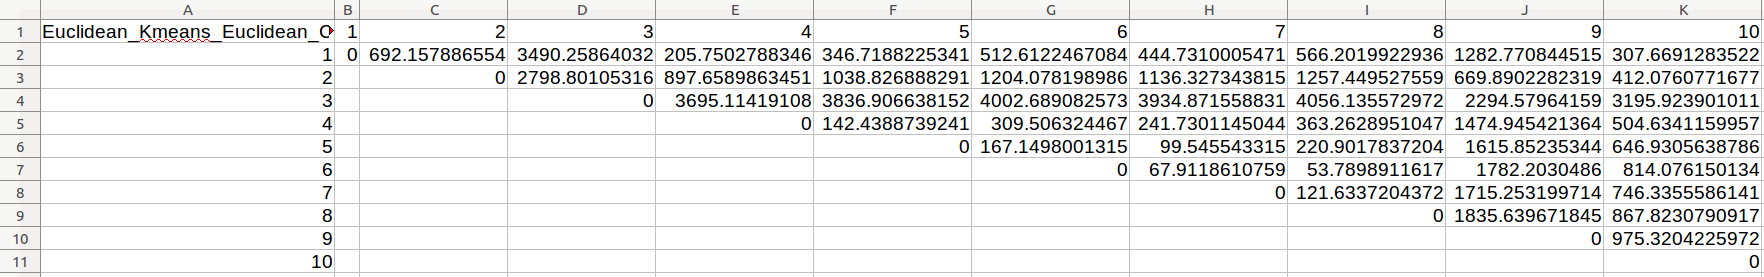

In [19]:
#nodes以c1為initial centroids，使用Euclidean算Kmeans，用Manhattan算最終centroid彼此的距離。
draw_csv("Euclidean_Kmeans_Manhattan_C1", euc1.cartesian(euc1).map(Manhattan_c).sortByKey().map(lambda x: ((x[0], x[1][0]), x[1][1])).sortByKey().collect())

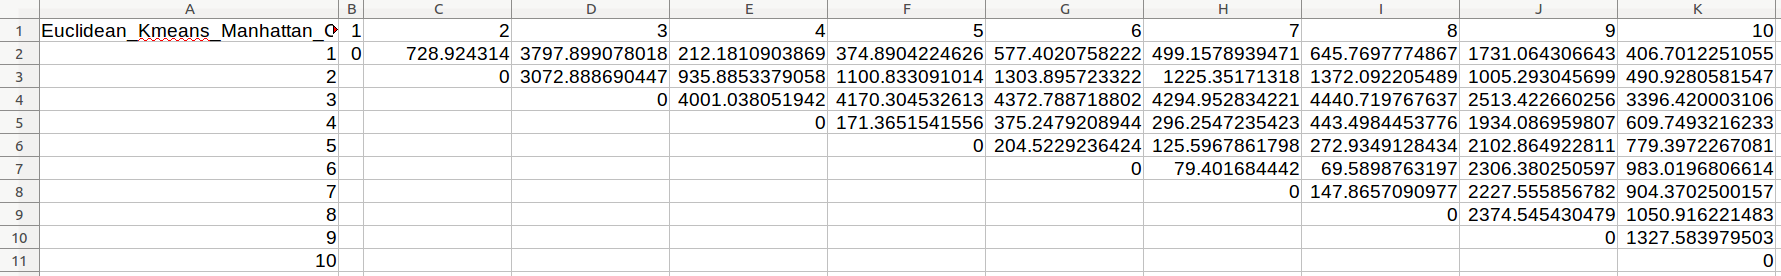

In [20]:
#nodes以c2為initial centroids，使用Euclidean算Kmeans，用Euclidean算最終centroid彼此的距離。
draw_csv("Euclidean_Kmeans_Euclidean_C2", euc2.cartesian(euc2).map(Euclidean_c).sortByKey().map(lambda x: ((x[0], x[1][0]), x[1][1])).sortByKey().collect())

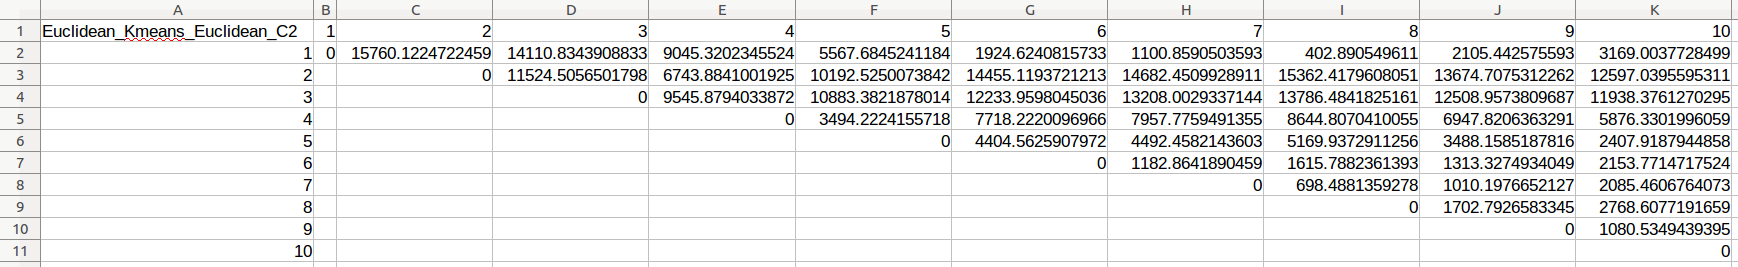

In [21]:
#nodes以c2為initial centroids，使用Euclidean算Kmeans，用Manhattan算最終centroid彼此的距離。
draw_csv("Euclidean_Kmeans_Manhattan_C2", euc2.cartesian(euc2).map(Manhattan_c).sortByKey().map(lambda x: ((x[0], x[1][0]), x[1][1])).sortByKey().collect())

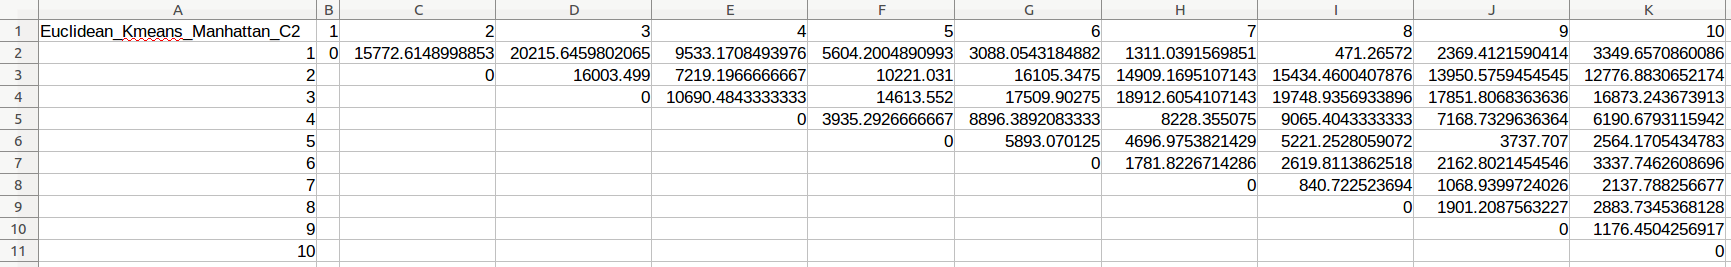

In [22]:
#nodes以c1為initial centroids，使用Manhattan算Kmeans，用Euclidean算最終centroid彼此的距離。
draw_csv("Manhattan_Kmeans_Euclidean_C1", mac1.cartesian(mac1).map(Euclidean_c).sortByKey().map(lambda x: ((x[0], x[1][0]), x[1][1])).sortByKey().collect())

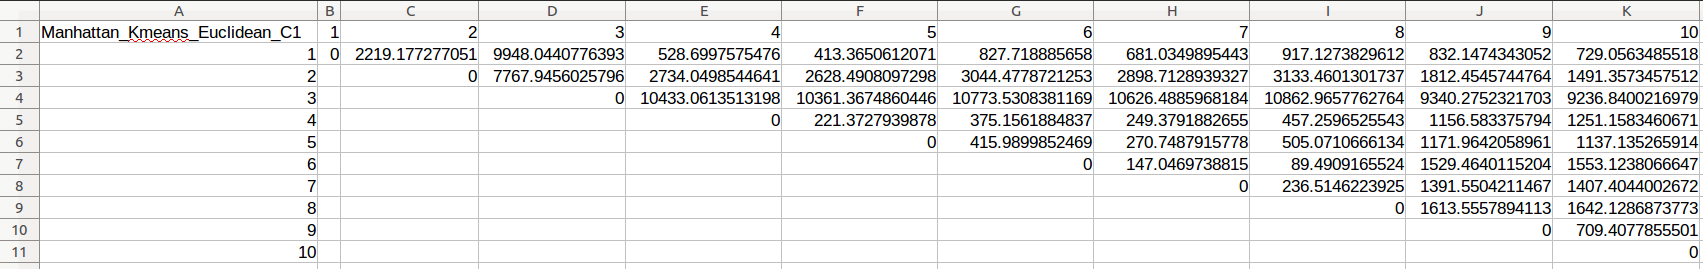

In [23]:
#nodes以c1為initial centroids，使用Manhattan算Kmeans，用Manhattan算最終centroid彼此的距離。
draw_csv("Manhattan_Kmeans_Manhattan_C1", mac1.cartesian(mac1).map(Manhattan_c).sortByKey().map(lambda x: ((x[0], x[1][0]), x[1][1])).sortByKey().collect())

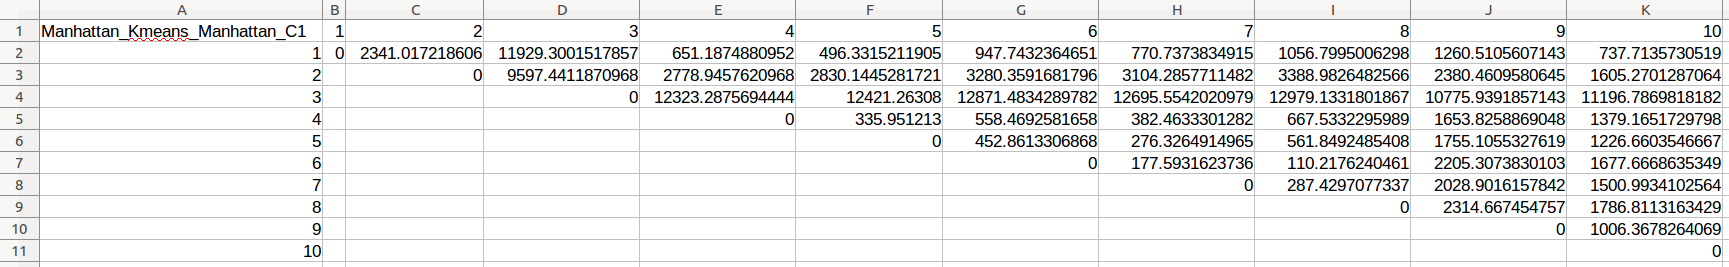

In [24]:
#nodes以c2為initial centroids，使用Manhattan算Kmeans，用Euclidean算最終centroid彼此的距離。
draw_csv("Manhattan_Kmeans_Euclidean_C2", mac2.cartesian(mac2).map(Euclidean_c).sortByKey().map(lambda x: ((x[0], x[1][0]), x[1][1])).sortByKey().collect())

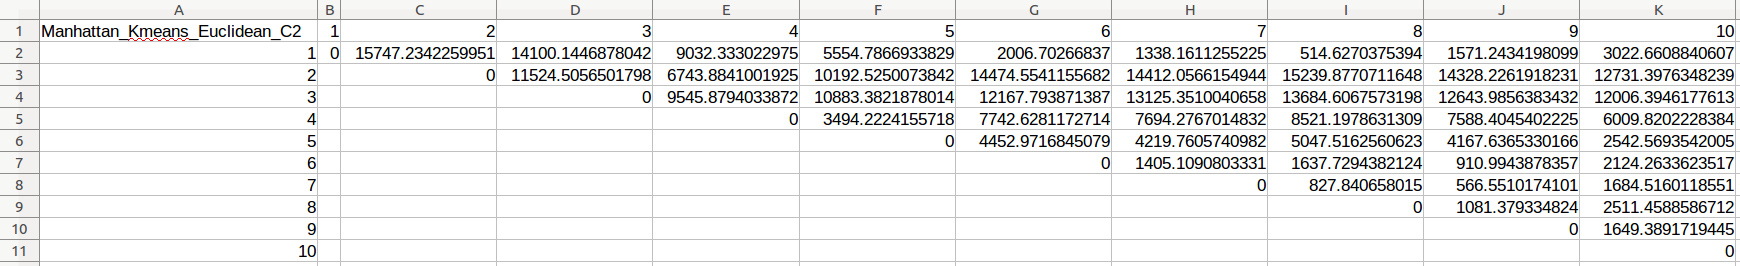

In [25]:
#nodes以c2為initial centroids，使用Manhattan算Kmeans，用Manhattan算最終centroid彼此的距離。
draw_csv("Manhattan_Kmeans_Manhattan_C2", mac2.cartesian(mac2).map(Manhattan_c).sortByKey().map(lambda x: ((x[0], x[1][0]), x[1][1])).sortByKey().collect())

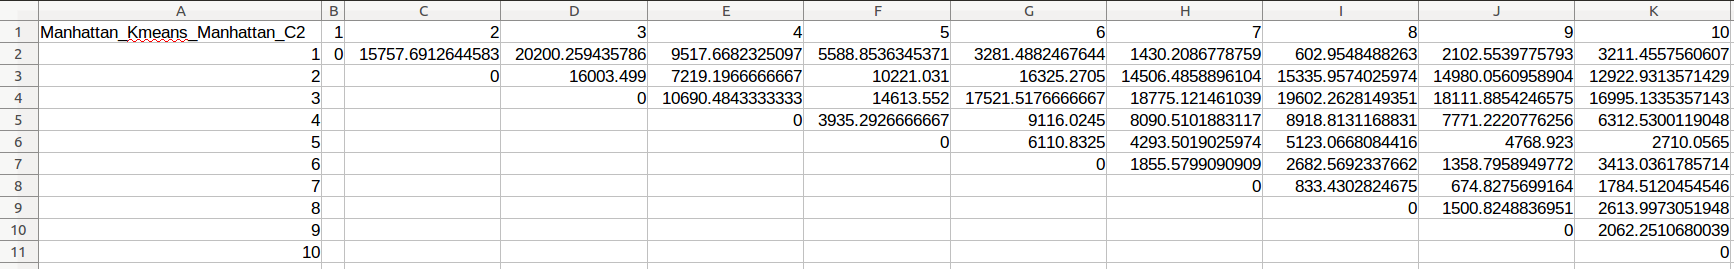

<font size="3">畫出c1與c2以Euclidean Distance、Manhattan Distance在各個iteration的cost圖。</font><br>

In [26]:
def draw_cost_log(x=None, y1=None, y2=None, title=None):
    plt.plot(x, y1, label="c1")
    plt.plot(x, y2, label="c2")
    plt.title("Cost of "+str(title))
    plt.xlabel("iteration")
    plt.ylabel("cost")
    plt.legend()
    plt.tight_layout()
    plt.savefig('./results/'+str(title)+".png")
    plt.close()

In [27]:
#Eulidean Distance
draw_cost_log(x=[i for i in range(0, MAX_ITER+1)], y1=eu_c1_cost_log, y2=eu_c2_cost_log, title="Euclidean Distance")
print('c1 cost : '+str((abs(eu_c1_cost_log[20] - eu_c1_cost_log[0]) / eu_c1_cost_log[0])*100)+'%')
print('c2 cost : '+str((abs(eu_c2_cost_log[20] - eu_c2_cost_log[0]) / eu_c2_cost_log[0])*100)+'%')

c1 cost : 26.926688255089616%
c2 cost : 79.45006380438356%


由於Eulidean算法會使得如果離中心相差很遠的話就會得到很大的值(取差距的平方)，又因為c2比c1初始點較為分散，因此c1會比c2更有可能有更多離中心點很遠的點，因此c1 cost比c2 cost高。而c1的初始分佈沒有c2分散，就算到收斂後各中心也不見得能散開(c1最後結果中心點彼此的差距較c2小)，因此c1的點收斂後cost仍比c2大。
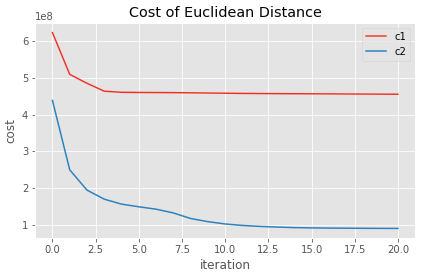

In [28]:
#Manhattan Distance
draw_cost_log(x=[i for i in range(0, MAX_ITER+1)], y1=ma_c1_cost_log, y2=ma_c2_cost_log, title="Manhattan Distance")
print('c1 cost : '+str((abs(ma_c1_cost_log[MAX_ITER] - ma_c1_cost_log[0]) / ma_c1_cost_log[0])*100)+'%')
print('c2 cost : '+str((abs(ma_c2_cost_log[MAX_ITER] - ma_c2_cost_log[0]) / ma_c2_cost_log[0])*100)+'%')

c1 cost : 18.78631277967278%
c2 cost : 54.90943478310846%


由於Manhattan算法不會像Euclidean那樣給離中心相差很遠的nodes那麼大的cost(取差距的絕對值)，又由於c2選的初始中心彼此之間距離較c1分散，因此得到的cost會比c1大。
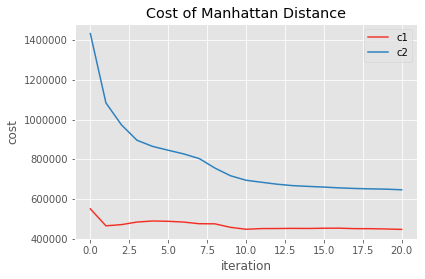